In [1]:
#!pip install --no-deps monai -q
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seismic-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_nn
import seis_test
import seis_prior
import seis_invert

float


In [2]:
# %%time
# import seis_test
# seis_test.run_all_tests()

In [3]:
data=kgs.load_all_train_data(validation_only=True)
data_flatvel = []
for d in data:
    if 'FlatVel' in d.family:
        data_flatvel.append(d)
len(data_flatvel)
data_flatvel = data_flatvel[::100]

In [4]:
model = kgs.ChainedModel()
model.models.append(seis_nn.make_default_pretrained())
model.models.append(seis_invert.InversionModel(prior=seis_prior.RowTotalVariation(λ=1e-8)))
#model.models[-1].method = 'L-BFGS-B'
model.models[-1].run_in_parallel = True
model.train([], []) # dummy

F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed1_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
Loading:  F:/seismic/models/brendan\bartley_unet2d_convnext_seed2_epochbest_FT.pth
Replacing all activations with GELU...
Replacing all norms with InstanceNorm...
Replacing forward functions...
n_models: 2


In [5]:
data_out = model.models[0].infer(data_flatvel)
kgs.score_metric(data_out);

      family     score
0  FlatVel_A  1.566163
1  FlatVel_B  5.686122
Combined:  3.626143


In [6]:
%%time
data_out = model.infer(data_flatvel)
kgs.score_metric(data_out);

Processing: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:53<00:00,  5.39s/it]

      family      score
0  FlatVel_A   1.122326
1  FlatVel_B  13.467039
Combined:  7.29468246186119
CPU times: total: 672 ms
Wall time: 54.7 s


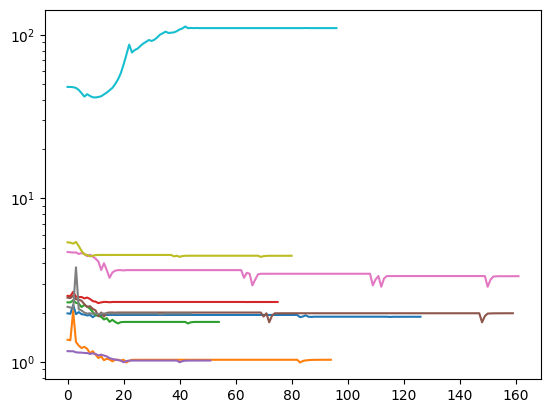

In [7]:
plt.figure()
for d in data_out:
    plt.semilogy([x for x in d.diagnostics['seis_to_vel']['vel_error_per_fev']])

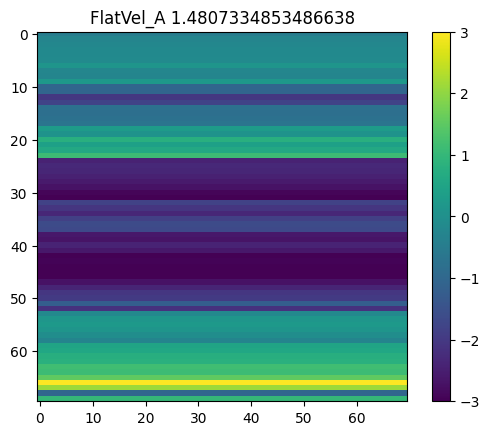

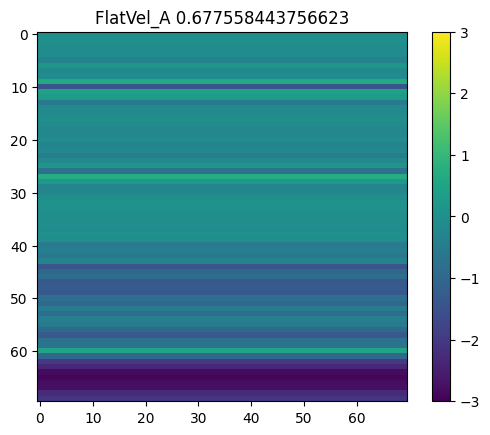

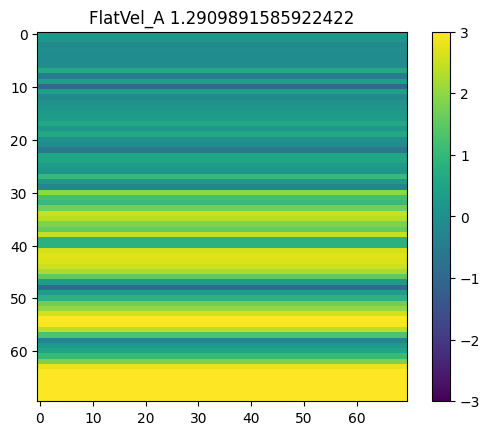

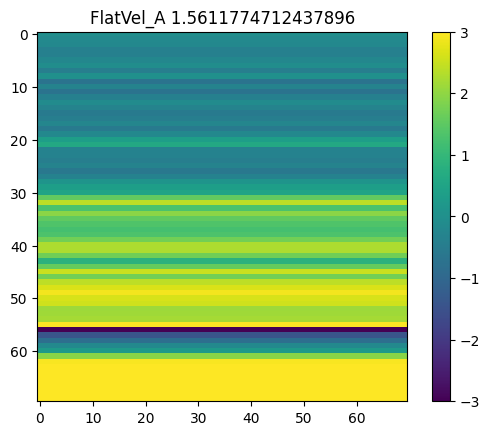

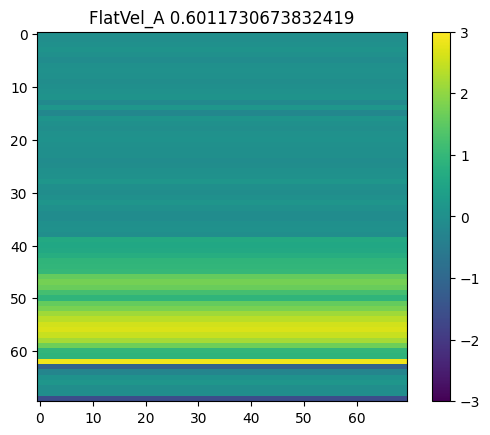

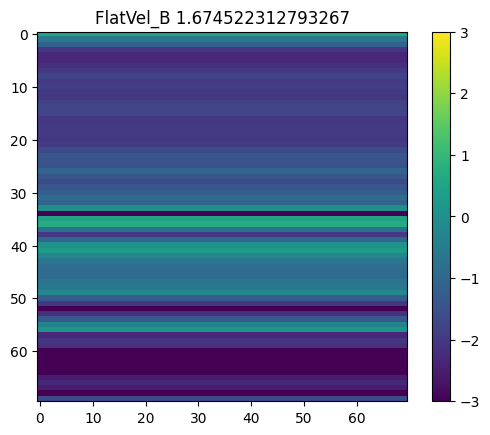

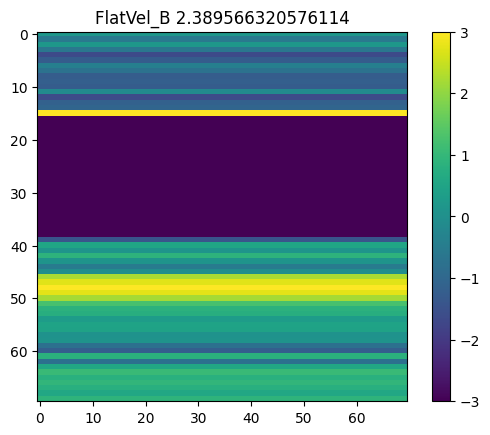

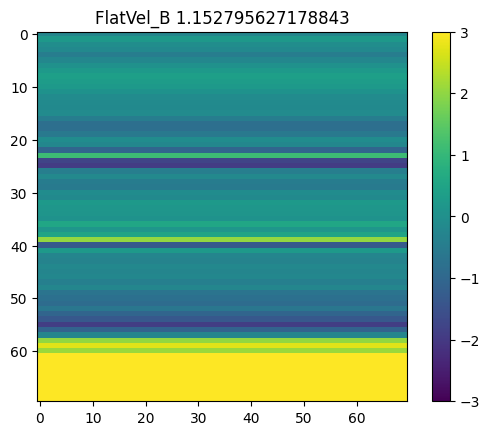

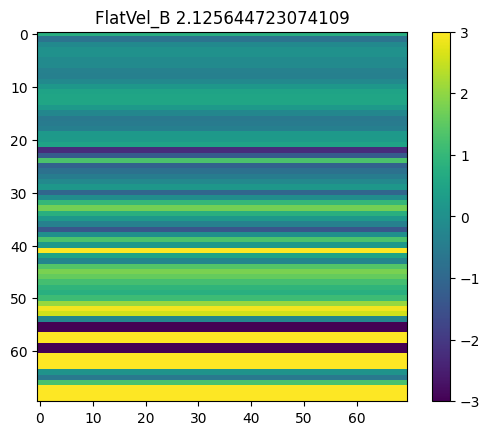

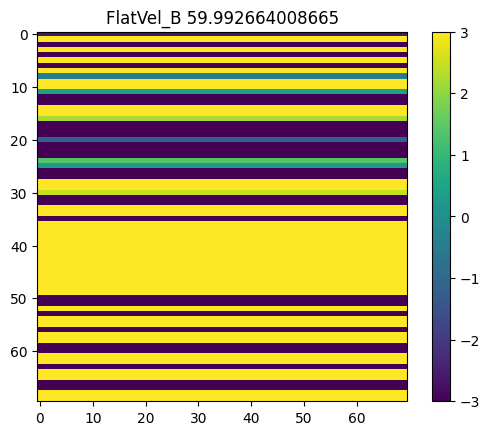

In [8]:
import cupy as cp
for d in data_out:
    d.load_to_memory()
    plt.figure()
    plt.imshow(d.velocity_guess.data - cp.asnumpy(d.velocity.data));plt.clim([-3,3]);plt.colorbar();
    plt.title(d.family+ ' ' +str(np.mean(np.abs(d.velocity_guess.data - cp.asnumpy(d.velocity.data)))))